In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

import musicnet

from time import time
from nnAudio import Spectrogram

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = "cuda:0"


In [2]:
# Network Parameters
epochs = 20
train_size = 100000
test_size = 50000

lr = 1e-6
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': False, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

# Preparing Dataset

In [7]:
# Change this directories to match your own path
# Run once with first root_2 uncommented and then run with the second root_2 uncommented (comment out the first one) 

root_1 = './data'
root_2 = '../MAPS/TEST3/'

In [8]:
start = time()
train_set = musicnet.MusicNet(root=root_1, epoch_size=train_size,sequence=sequence
                              , train=True, download=False, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root_2, train=False, download=False,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)


print("TRAIN ", train_set.rec_ids)
print("TEST ", test_set.rec_ids)

# with train_set, test_set:
#     for i, (x_test,y_test) in enumerate(test_loader):
#         print(x_test,y_test)

Data loaded, time used = 33.43 seconds
TRAIN  [2207, 2315, 2392, 1757, 2477, 2320, 2480, 2390, 2677, 2466, 2342, 1756, 2555, 2629, 2582, 2217, 2659, 2471, 2161, 2292, 2530, 2322, 2618, 2239, 2313, 2343, 2593, 2220, 2247, 2532, 2523, 1931, 2373, 1918, 2180, 2077, 2376, 2391, 2302, 2478, 2621, 1742, 2505, 2346, 2140, 1893, 1735, 2186, 1812, 2568, 2307, 2080, 1751, 2572, 1764, 2167, 2300, 2473, 2627, 2531, 2487, 2238, 2397, 2179, 1775, 2288, 2198, 2420, 2476, 2242, 2284, 2138, 2177, 1791, 2404, 2297, 2497, 2336, 2234, 2166, 2410, 2433, 2308, 2522, 2368, 2229, 2201, 2494, 2384, 2218, 2195, 2436, 2083, 1805, 2575, 1859, 2240, 2295, 2423, 1829, 2237, 2462, 2571, 2393, 2168, 1916, 2155, 2371, 1773, 2219, 2225, 2212, 1765, 2590, 2483, 2196, 2595, 2305, 2529, 2472, 1835, 2104, 2486, 2294, 2364, 2209, 2422, 2345, 2481, 2147, 2502, 2112, 2432, 2509, 2560, 2149, 2591, 2614, 2566, 1772, 1776, 2594, 1872, 2405, 1768, 1822, 2611, 2570, 1730, 2296, 2603, 2372, 2622, 2127, 1923, 2358, 1933, 2619, 2304,

# Defining Models

In [9]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [10]:
# freq_bins = 4096
# epsilon=1e-5
# class Model(torch.nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         # Getting Mel Spectrogram on the fly

#         self.STFT_layer = Spectrogram.STFT(sr=44100, n_fft=n_fft, freq_bins=freq_bins, fmin=50, fmax=6000, freq_scale='log', pad_mode='constant', center=True)
#         self.n_bins = freq_bins
#         # Creating Layers
#         self.linear = torch.nn.Linear(self.n_bins*regions, m, bias=False)
#         torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
#     def forward(self,x):
#         z = self.STFT_layer(x)
#         y = self.linear((torch.log(z+epsilon)).view(x.data.size()[0], self.n_bins*regions))
#         return torch.sigmoid(y)

In [11]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows for stft
        wsin, wcos = musicnet.create_filters(n_fft,k, windowing="hann", freq_scale='log')
        self.wsin = torch.tensor(wsin, dtype=torch.float).to(device)
        self.wcos = torch.tensor(wcos, dtype=torch.float).to(device)
     
        # Creating Layers
        self.linear = torch.nn.Linear(25*k, m, bias=False)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2) # Doing STFT by using conv1d
#         print(zx.shape)
        return self.linear(torch.log(zx + 10e-8).view(x.data.size()[0],25*k))
    

In [12]:
model = Model()
model.to(device)

Model(
  (linear): Linear(in_features=12800, out_features=128, bias=False)
)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  
            
            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)
            
            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime
0	0.958233	1.190693	0.592302	0.736115	29.8	9.8
1	0.907198	1.162607	0.640043	0.745965	30.1	10.0
2	0.897607	1.198708	0.645182	0.743094	29.8	9.8
3	0.891274	1.180117	0.650638	0.741658	30.3	10.4
4	0.892629	1.188251	0.649764	0.743969	30.9	9.8
5	0.886107	1.178786	0.656574	0.747027	29.8	9.8
6	0.892894	1.182066	0.653633	0.745374	29.7	9.8
7	0.885768	1.191929	0.655870	0.736378	29.7	9.8
8	0.890062	1.180282	0.654291	0.739609	29.8	9.8
9	0.888915	1.186128	0.655620	0.738530	29.7	9.8
10	0.884319	1.206805	0.657713	0.737109	29.8	9.8
11	0.887964	1.176542	0.656682	0.742177	29.9	9.8
12	0.884656	1.190220	0.657752	0.747212	31.6	9.9
13	0.887417	1.185186	0.656725	0.741857	29.8	10.0
14	0.884894	1.159935	0.657929	0.743473	29.6	9.8
15	0.883734	1.168030	0.658438	0.746171	29.6	9.8
16	0.887358	1.181543	0.657234	0.741468	29.6	9.7
17	0.880648	1.203131	0.657526	0.743392	29.7	9.7
18	0.886234	1.158414	0.657964	0.742933	29.5	9.7
19	0.886807	1.225804	0.657928	0.737606

(0.3, 0.8)

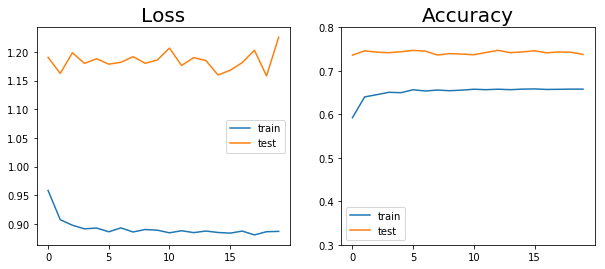

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

# Mir_Eval stats

In [16]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
Pavg = 0
Ravg = 0
model.eval()
for songid in test_set.rec_ids:
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model, device,
                                             window=window, m=m, stride=-1)
    _,P,R,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot
    Pavg += P
    Ravg += R

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.80	90.65	49.68	0.47	0.53	0.03	0.48	0.03        
76.56	92.80	25.43	0.25	0.75	0.02	0.73	0.00        
89.62	94.85	66.76	0.64	0.35	0.02	0.31	0.02        
89.36	95.06	71.75	0.69	0.30	0.02	0.27	0.02        
73.01	90.28	30.37	0.29	0.72	0.01	0.68	0.02        
59.39	65.80	41.40	0.34	0.71	0.09	0.49	0.12        
78.53	92.71	38.62	0.37	0.62	0.02	0.59	0.01        
76.04	90.88	38.30	0.37	0.63	0.02	0.59	0.01        
75.94	92.64	36.25	0.35	0.65	0.02	0.62	0.01        
82.52	90.15	58.93	0.55	0.45	0.03	0.38	0.04        
77.51	91.63	43.78	0.42	0.59	0.01	0.55	0.03        
50.78	53.34	44.47	0.32	0.88	0.06	0.49	0.32        
57.62	78.78	29.03	0.27	0.76	0.03	0.68	0.05        
52.64	76.64	27.80	0.26	0.78	0.03	0.69	0.06        
59.10	86.87	23.53	0.23	0.79	0.01	0.75	0.02        
68.54	96.94	29.99	0.30	0.70	0.01	0.69	0.00        
75.25	80.00	52.59	0.46	0.54	0.07	0.40	0.06        
80.10	87.28	57.89	0.53	0.45	0.06	0.37	0.03        
79.47	77.88	68.73	0.58	0.43	0.08	0.24	0.12       

In [21]:
print(len(test_set))
print('Average Precision: \t{:2.2f}\nAverage Recall: \t{:2.2f}'
      .format(Pavg/len(test_set.rec_ids)*100, Ravg/len(test_set.rec_ids)*100))

50000
Average Precision: 	86.25
Average Recall: 	49.65


In [22]:
print(len(test_set))
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))

50000
Average Accuracy: 	45.72
Average Error: 		55.18


# Saving weights and results

In [23]:
torch.save(model.state_dict(), './weights/MAPS')
with open('./result_dict/MAPS', 'wb') as f:
    pickle.dump(result_dict, f)